# Финальный проект

# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

C:\Users\Felixalex\miniconda3\envs\practicum\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Felixalex\miniconda3\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Felixalex\miniconda3\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## EDA - Исследовательский анализ данных

Чтобы не дублировать код, сделаем функцию

In [2]:
def data_load(name):
    #загружаем данные
    try:
        data = pd.read_csv('datasets/' + name)
    except:
        data = pd.read_csv('/datasets/final_steel/' + name)
    #осматриваем первые 5 строк датасета
    display(data.head())
    #выводим информацию о датасете
    data.info()
    #Выводим описание числовых колонок
    display(data.describe())
#     display(data.corr().style.background_gradient(cmap='coolwarm'))
    return data

### Загрузим и осмотрим данные об электродах

In [3]:
data_arc = data_load('data_arc.csv')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [ ]:
data_arc

<AxesSubplot: xlabel='Активная мощность', ylabel='Реактивная мощность'>

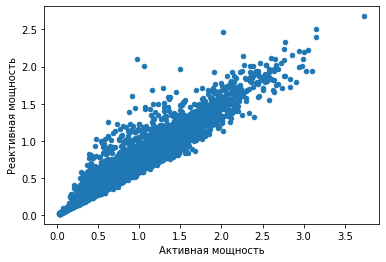

In [11]:
data_arc[data_arc['Реактивная мощность'] > 0].plot(kind='scatter',x='Активная мощность',y='Реактивная мощность')

In [12]:
data_arc[data_arc['Реактивная мощность'] > 0].corr()

C:\Users\Felixalex\AppData\Local\Temp\ipykernel_14196\4111005759.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_arc[data_arc['Реактивная мощность'] > 0].corr()


,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021367,-0.000159
Активная мощность,-0.021367,1.000000,0.963182
Реактивная мощность,-0.000159,0.963182,1.000000


Названия колонок говорят сами за себя. Пропусков не имеем
Что нужно сделать:
1) поменять названия колонок
2) поменять тип данных
3) сделать что-то с выбросами, как минимум 1 уже виден

`Идея 1` - можем посчитать энергию переданную сплаву как произведение активной мощности на затраченное время (его получим из дельты между временем начала нагрева и временем конца нагрева), таким образом получим новый признак.

In [4]:
#изменяем название колонок
data_arc.columns = ['key', 'arc_start_time', 'arc_end_time', 'active_power', 'reactive_power']
#меняем тип данных на datetime
data_arc[['arc_start_time', 'arc_end_time']] = data_arc[['arc_start_time', 'arc_end_time']].apply(pd.to_datetime)
data_arc

,key,arc_start_time,arc_end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


Посмотрим на распределение подаваемой мощности по разным партиям

In [5]:
%matplotlib inline
sns.set_style('darkgrid')

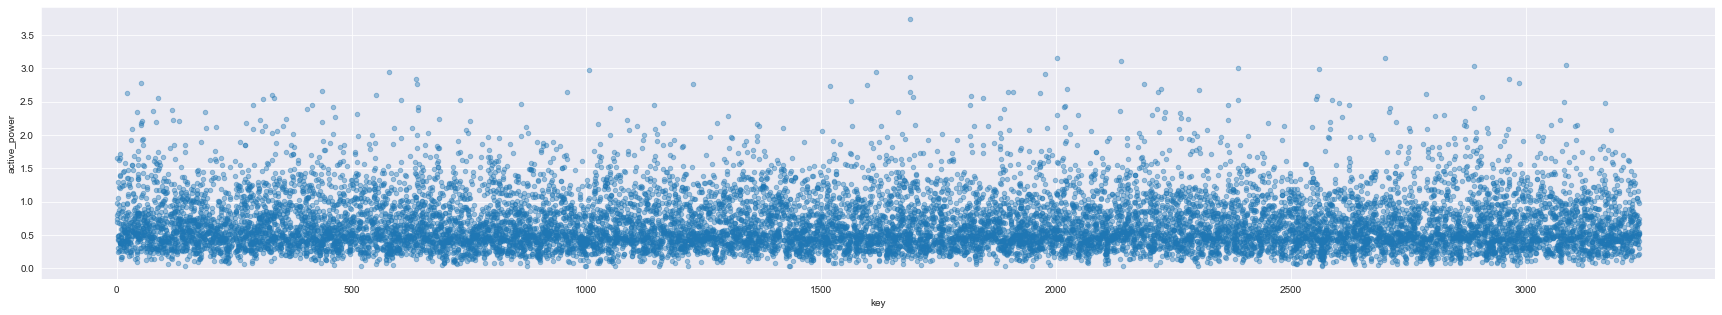

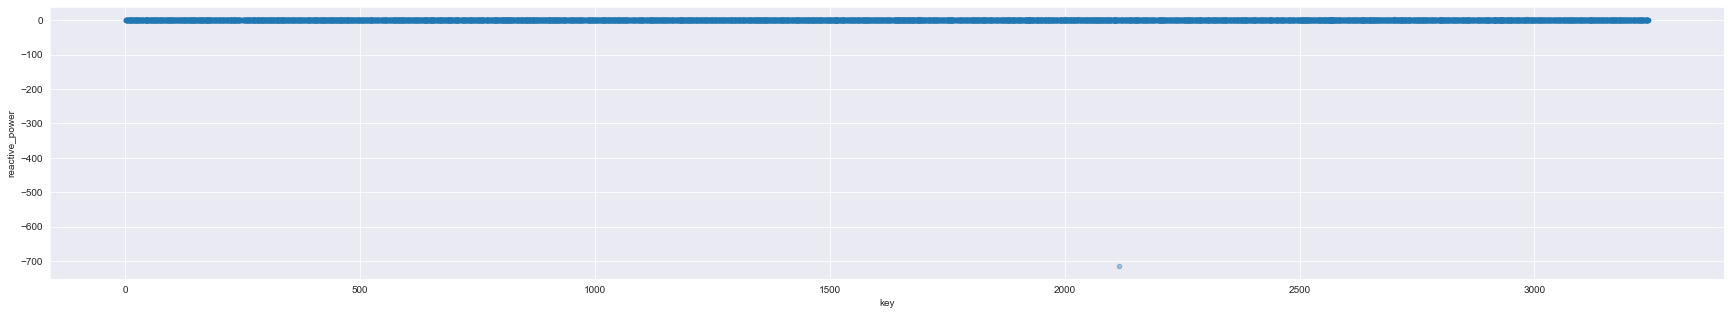

In [6]:
data_arc.plot(x='key', y='active_power', kind='scatter', figsize = (30,5), alpha=0.4)
data_arc.plot(x='key', y='reactive_power', kind='scatter', figsize = (30,5), alpha=0.4)
plt.show()

По активной мощности распределение по партиям равномерное, без выбросов

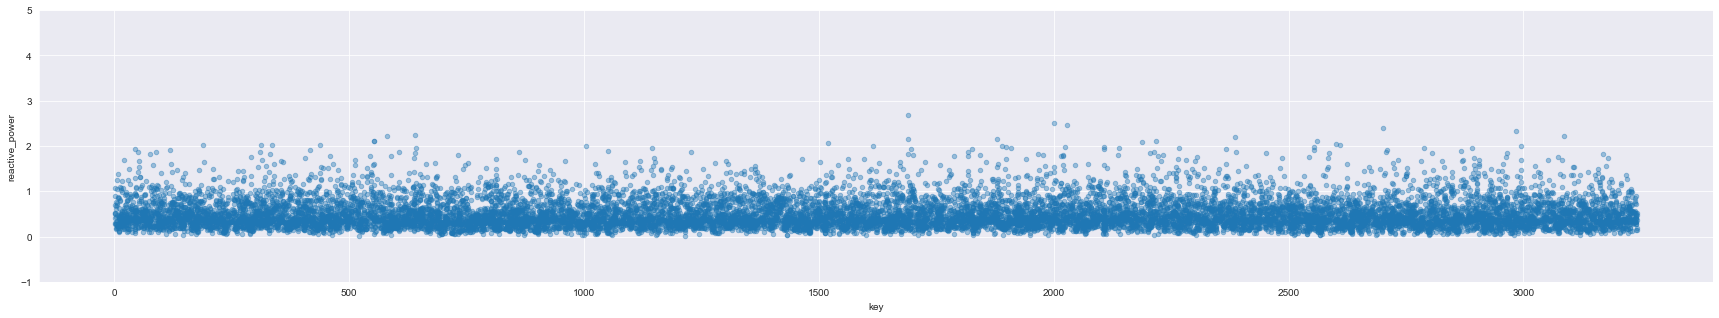

In [7]:
data_arc.plot(x='key', y='reactive_power', kind='scatter', figsize = (30,5), ylim=(-1, 5), alpha=0.4)
plt.show()

За исключением выброса распределение тоже равномерное.

По графикам не заметно, что подаваемая на электроды мощность сильно отличается от партии к партии. Но масштаб довольно мал. Посмотрим средние значения активной мощности по каждой партии

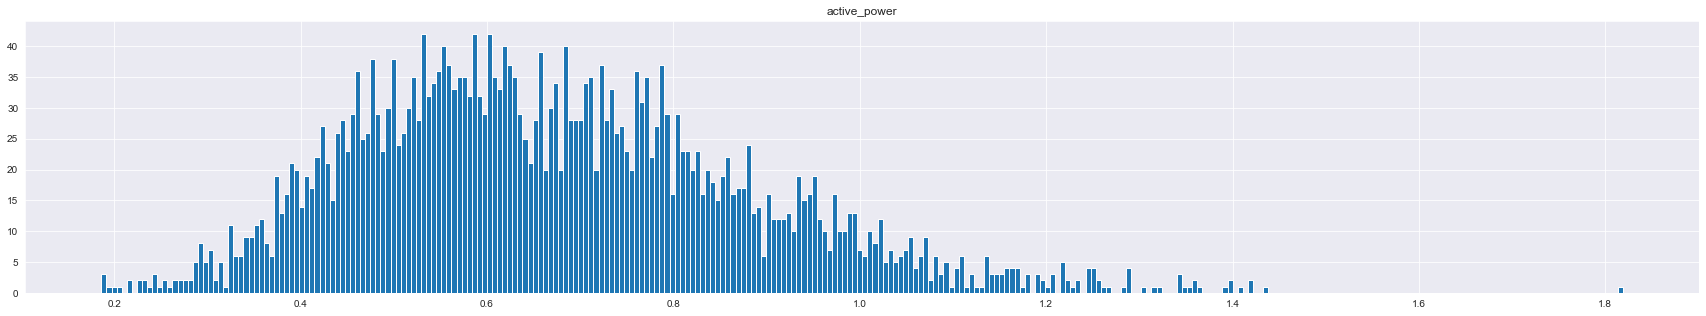

In [8]:
data_arc.pivot_table(index='key', values='active_power').sort_values('active_power').hist(bins=300, figsize=(30,5))
plt.show()

Теперь видно, что средняя активная мощность отличается от партии к партии. Распределение нормальное. Видимо, иногда сплав подогреть совсем чуть-чуть, а иногда сильно.

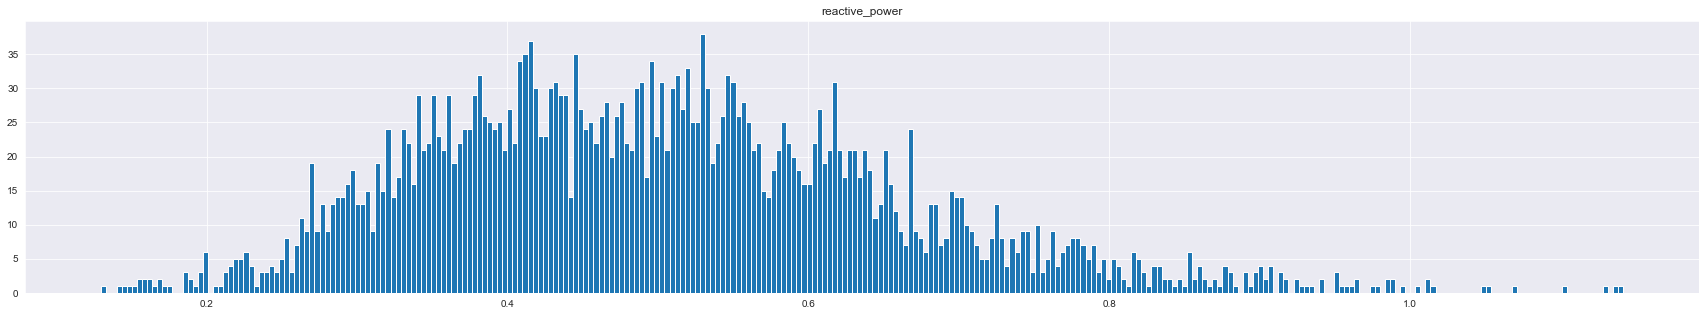

In [9]:
data_arc.pivot_table(index='key', values='reactive_power').sort_values('reactive_power')[1:].hist(bins=300, figsize=(30,5))
plt.show()

То же и с реактивной мощностью

`Вопрос 1` - узнать единицы измерения мощностей

### Загружаем и осматриваем данные о подаче сыпучих материалов

In [10]:
data_bulk = data_load('data_bulk.csv')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Что видим:
- `key` - количество 3129 не совпадает с количеством, которое было в предыдущей таблице
- Много пропусков. Видимо, это связано с тем, что сплавы в разных партиях отличаются и везде есть свои сыпучие материалы
- `Bulk 8` имеет только одно значение - скорее всего, эту партию придется выкинуть, т.к. на основании одного объекта нельзя обозначить четкую зависимость
- Много коррелирующих значений

`Идея 2` - Предположительно, `Nan'ы` нужно будет заменить нулями

In [11]:
print(f'Уникальных партий в data_arc: {data_arc["key"].nunique()} \nУникальных партий в data_bulc: {data_bulk["key"].nunique()}')

Уникальных партий в data_arc: 3214 
Уникальных партий в data_bulc: 3129


Значит, что для каких то партий у нас не хватит признаков и это придется пофиксить удалением данных (если данные по bulk нам, конечно, будут в итоге нужны)

Сменим сразу названия колонок

In [12]:
def rename_cols_sc(df):
    tmp = []
    for i in df.columns.to_list():
        i = i.replace(' ','_').lower()
        tmp.append(i)
    df.columns = tmp

In [13]:
rename_cols_sc(data_bulk)
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


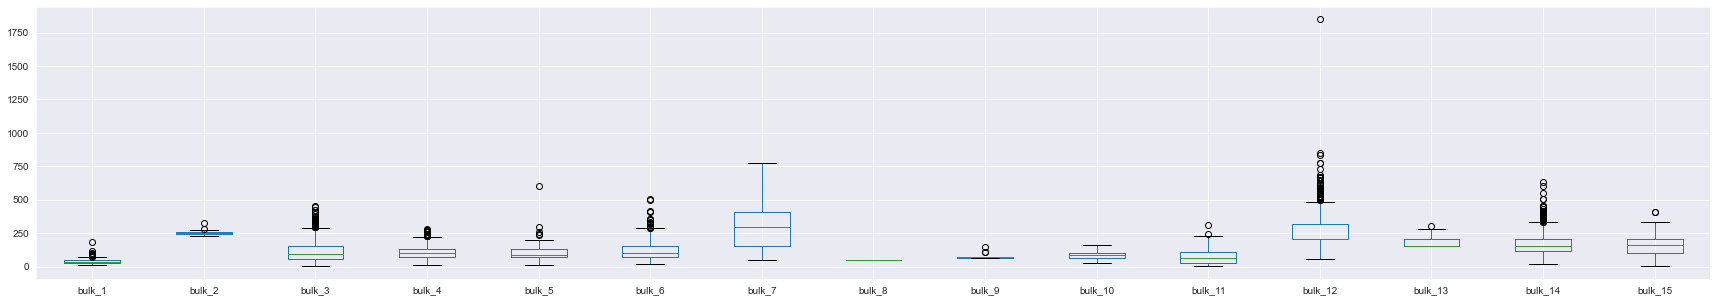

In [14]:
data_bulk.drop('key',axis=1).boxplot(figsize = (30,5))
plt.show()

`Вопрос 2` - bulk_12 - выбросы?

### Загружаем и осматриваем данные о времени подачи сыпучих материалов

In [15]:
data_bulk_time = data_load('data_bulk_time.csv')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Здесь имеем время подачи сыпучих веществ из предыдущей таблицы. Пока непонятно как это использовать. Но поменять тип данных на datetime и сменить названия колонок нам никто не запрещает

In [16]:
#сменим названия колонок
rename_cols_sc(data_bulk_time)

In [17]:
#меняем тип данных на datetime
data_bulk_time[data_bulk_time.columns.drop('key')] = data_bulk_time[data_bulk_time.columns.drop('key')].apply(pd.to_datetime)

### Загружаем и осматриваем данные о подаче газа

In [18]:
data_gas = data_load('data_gas.csv')

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Данные показывают сколько газа подавалось в каждую партию. Потом добавим в финальную таблицу. Сменим названия колонок

In [19]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas_1'})

Посмотрим на выбросы

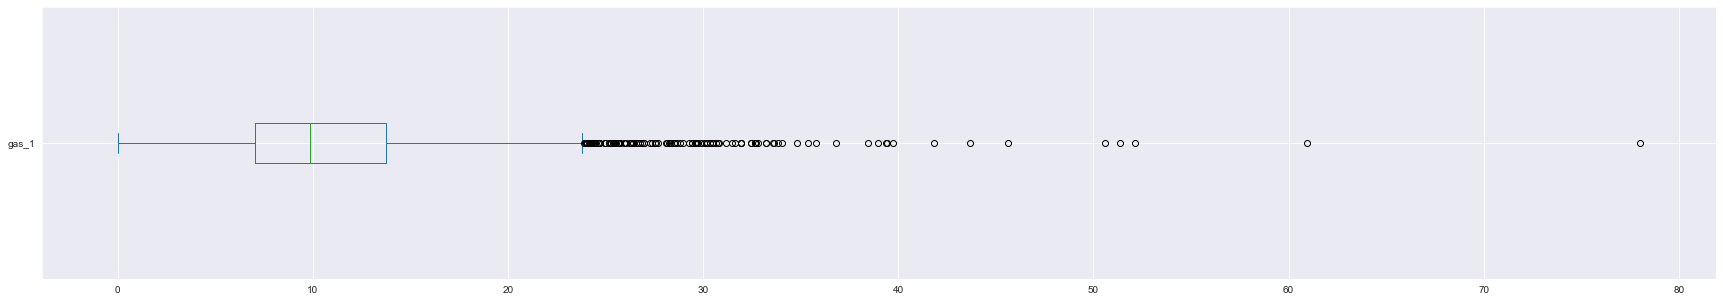

In [20]:
data_gas['gas_1'].plot(kind='box',vert=False, figsize=(30,5))
plt.show()

Видны выбросы.
`Вопрос 3` - узнать у заказчика, насколько эти выбросы выбиваются из тех.процесса

### Загружаем и осматриваем данные по температуре

In [21]:
data_temp = data_load('data_temp.csv')

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Данные отображают промежуточные измерения температуры по разным партиям в процессе выплавыки.

Есть пропуски. Можем удалить или заполнить.

Видно, что минимальное значение ниже, чем температура плавления материала. Заказчик говорит, что это баг, а не фича, и нужно удалить.

In [22]:
data_temp = data_temp.rename(columns={'Температура': 'temperature', 'Время замера': 'measurment_time'})
data_temp['measurment_time'] = data_temp['measurment_time'].apply(pd.to_datetime)

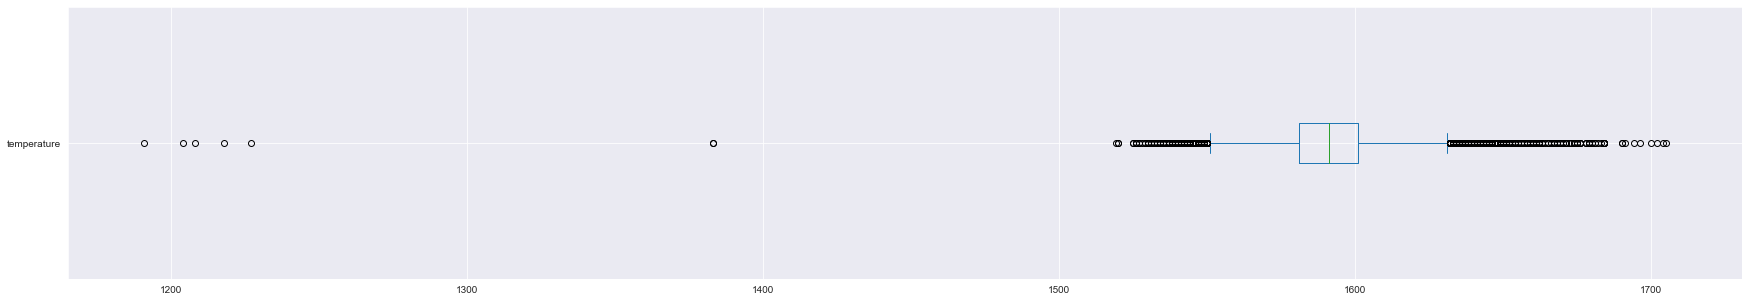

In [23]:
data_temp['temperature'].plot(kind='box', figsize=(30,5),vert=False)
plt.show()

Такое значение не одно. `Вопрос 4` - признаем аномалиями в измерениях или работники не уследили и котел остывал?

In [24]:
data_temp[data_temp['temperature'].isna()]

,key,measurment_time,temperature
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Пропуски принадлежат в основном последним партиям. Видимо, реле к концу работы стало барахлить. Посмотрим на срез по ключу с пропуском

In [25]:
data_temp[data_temp['key'] == 2500]

,key,measurment_time,temperature
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN


In [26]:
data_arc[data_arc['key'] == 2500]

,key,arc_start_time,arc_end_time,active_power,reactive_power
11449,2500,2019-08-06 03:04:14,2019-08-06 03:08:50,1.189401,0.967902
11450,2500,2019-08-06 03:12:46,2019-08-06 03:16:47,1.141624,0.839004
11451,2500,2019-08-06 03:17:47,2019-08-06 03:22:27,1.307359,0.941409
11452,2500,2019-08-06 03:25:28,2019-08-06 03:26:25,0.240430,0.195125


In [27]:
data_bulk_time[data_bulk_time['key']==2500]

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2408,2500,NaT,NaT,2019-08-06 03:10:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-06 03:05:27,NaT,2019-08-06 03:05:28,2019-08-06 03:05:27


Имеем только первоначальную температуру после загрузки и первичного подогрева

`Идея 3` - толку от таких данных не много. Ошибка чревата недостаточной температурой котла и простоем производства. Похоже, что нужно будет удалить все ключи с пропусками. 

`Вопрос 5` - подогрев начинается еще ДО подачи материалов. На что он расходуется? на подогрев самого котла? Или bulk - это только легирующие вещества, а в котле уже имеется сплав? если да, то масса сплава всегда одинакова?

`Идея 4` - конечная температура - самый полезный показатель, т.к. она является итоговой после всех операций подогрева. Хотя мы можем использовать в признаках и промежуточные температуры, если операции загрузки исходных веществ и подогрева ей предшествуют. Таким образом получим больше объектов для загрузки в модель.

### Загружаем и осматриваем данные о проволочных материалах

In [28]:
data_wire = data_load('data_wire.csv')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Как и в случае с bulk, видим, что некоторые значения wire представлены всего лишь несколькими объектами.

По обычаю приведем названия колонок к snake_case

In [29]:
rename_cols_sc(data_wire)

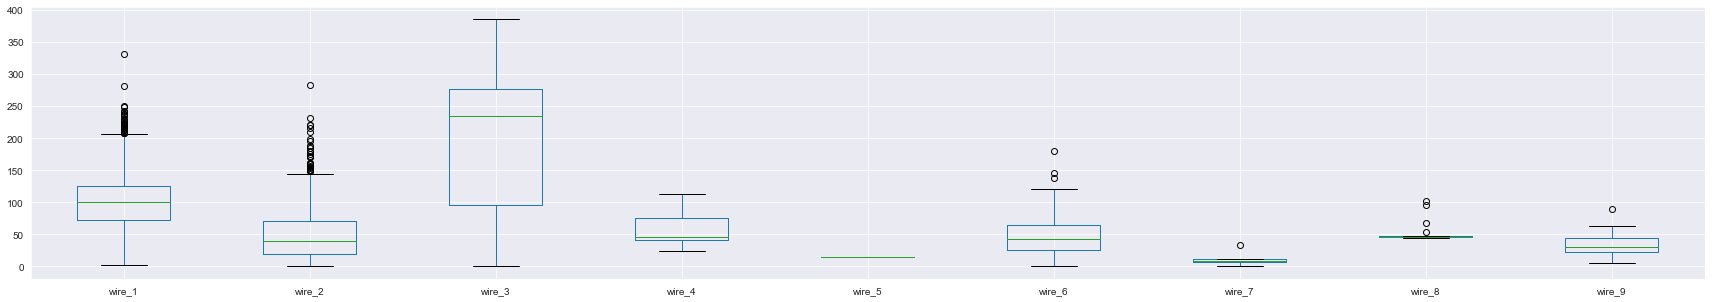

In [30]:
data_wire.drop('key', axis=1).boxplot(figsize=(30,5))
plt.show()

`Вопрос 6` - что имеется в виду под wire? То же самое, что и bulk, только "в профиль"?

### Загружаем и осматриваем данные о времени подачи проволочных материалов

In [31]:
data_wire_time = data_load('data_wire_time.csv')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Приведем названия к snake_case, а время к datetime

In [32]:
#колонки к snake_case
rename_cols_sc(data_wire_time)

In [33]:
#меняем тип данных на datetime
data_wire_time[data_wire_time.columns.drop('key')] = data_wire_time[data_wire_time.columns.drop('key')].apply(pd.to_datetime)

### Резюмируем идеи и вопросы, а также составляем план работы
Идеи:
- Генерируем признак energy_expended, который будет представлять собой сумму активных мощностей для каждой конкретной партии, умноженных на время нагрева
- Пропущенные значения в data_bulk и data_wire заменим нулями. Раз NaN - значит ничего не подается
- Значения температуры ДО подачи легирующих примесей и нагрева нужны только если имеем соответствующие температуры ПОСЛЕ подачи примесей и нагрева, иначе эти данные бесполезны и их стоит удалить
- Промежуточные температуры могут использоваться как дополнительные объекты для наблюдения, если перед каждым подобным замером присутствует нагрев сплава

Вопросы:
- Узнать единицу измерения мощности, ведь если под мощностью подразумевается не мощность, а уже затраченная энергия, то первая идея бесполезна
- Считать ли выбросами значения выходящие за 1,5 межквартильных размаха на диаграмме размаха? наиболее заметно в bulk_12
- Температуры ниже 1500 аномалии, или работники не уследили за температурой? в первом случае наблюдения удалим, в последнем случае, предположительно, можем использовать наблюдения для измерения "скорости остывания"
- Подогрев начинается еще ДО подачи материалов. На что он расходуется? на подогрев самого котла? Или bulk - это только легирующие вещества, а в котле уже имеется сплав? если да, то масса сплава всегда одинакова?
- Есть ли принципиальное отличие между wire и bulk?

<font color='green'> ✔️Ответы:
- едиица измерения МВа или МВт, но это именно мощность, не энергия
- про выбросы  выше я написал, что можем удалить только из тренировочной выборки
- bulk и wire это легирующие, в печи у нас залита заготовка, в нее добавляют легирующие материалы, греют и так получается конечнный продукт, этот нагрев может свидетельствовать, что у нас или есть не синхронность датчиков(замеров времени) или сплав был температурой ниже чем требуется для начала процесса.
- проволочные и сыпучие материалы, одно по идеи легирующие  элементы, другие флюсы или шлакообразующих материалов и гранулированный шлак, но опять же заказчик ставит перед нами задачу, мы не знаем набор добавок, мы получается создаем математическую модель.</font>

### План работы

1) Получаем ответы на вопросы у заказчика, обсуждаем идеи с командой

2) В зависимости от п.1, удаляем/оставляем аномалии. 

3) В зависимости от п.1, генерируем новые признаки согласно идеям выше.

4) Делаем отбор признаков и собираем их в сводную таблицу. Разбиваем получившуюся выборку на тренировочную и тестовую.

5) Подбираем модели для решения. Предположительно будем пробовать лес, линейную регрессию и бустинг. Целевым признаком будет температура сплава. Для подбора гиперпараметров используем либо валидацию, либо кросс-валидацию с pipeline, последнее предпочтительней

## Обработка данных

### Обработка аномалий

Было принято решение удалить объекты связанные с низкой температурой (ниже 1500 градусов) и с отсутствующим целевым признаком

Удалять будем по ключу.

In [34]:
#формируем список ключей для удаления. Т.к. по словам заказчика это 100% аномалии, то удалять будем из всей выборки
keys_to_drop = data_temp[(data_temp['temperature'] < 1500) | (data_temp['key'] >= 2500)]['key'].to_list()
#добавляем сюда выброс по реактивной мощности
keys_to_drop += data_arc[data_arc['reactive_power'] < 0]['key'].to_list()

In [35]:
data_arc = data_arc[~data_arc['key'].isin(keys_to_drop)]
data_bulk = data_bulk[~data_bulk['key'].isin(keys_to_drop)]
data_bulk_time = data_bulk_time[~data_bulk_time['key'].isin(keys_to_drop)]
data_gas = data_gas[~data_gas['key'].isin(keys_to_drop)]
data_temp = data_temp[~data_temp['key'].isin(keys_to_drop)]
data_wire = data_wire[~data_wire['key'].isin(keys_to_drop)]
data_wire_time = data_wire_time[~data_wire_time['key'].isin(keys_to_drop)]

Все остальные аномалии будем обрабатывать уже после разделения на тренировочную и тестовые выборки (или в пайплайне). А может быть оставим как есть

### Обработка пропусков

Заполняем нулями пропуски в `data_bulk`

In [36]:
data_bulk = data_bulk.fillna(0)
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,2495,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2404,2496,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2405,2497,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2406,2498,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


Заполняем пропуски в `data_wire`

In [37]:
data_wire = data_wire.fillna(0)
data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2368,2495,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2369,2496,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2370,2497,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2371,2498,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Генерация признаков и составление финальной таблицы

### Выделяем начальную и конечную температуры

В начале обработки каждой партии сплава к нам на вход подается прекурсор, разогретый до какой-то температуры. Затем добавляются добавки и начинается перемешивание и подогрев сплава. Заказчик говорит, что время измерений подогрева / замеров температуры / подачи материала в разных таблицах не согласуются между собой. 

Значит, идея с генерацией признаков по промежуточным температурам отпадает. Выделяем первую температуру каждой партии как признак и последнюю температуру партии как таргет.

Воспользуемся сводной таблицей. Номер партии будет индексом.

In [38]:
data_temp = data_temp.pivot_table(index = 'key', values = 'temperature', aggfunc=['first','last'])
data_temp.columns = ['initial_temperature', 'final_temperature']
data_temp

,initial_temperature,final_temperature
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


### Расчет energy_expended 

Посчитаем значение полезной мощности для каждого подогрева. Остальное отбросим за ненадобностью.

In [39]:
data_arc['energy_expended'] = (data_arc['arc_end_time'] - data_arc['arc_start_time']).dt.seconds * data_arc['active_power']
data_arc

C:\Users\Felixalex\AppData\Local\Temp\ipykernel_21108\3028520918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['energy_expended'] = (data_arc['arc_end_time'] - data_arc['arc_start_time']).dt.seconds * data_arc['active_power']


,key,arc_start_time,arc_end_time,active_power,reactive_power,energy_expended
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,222.541395
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,149.037310
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,128.030509
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,605.667332
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,102.527702
...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,7.388752
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,444.870555
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,200.573342
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,407.472872


In [40]:
data_arc = data_arc.pivot_table(index='key', values='energy_expended', aggfunc='sum')
data_arc

,energy_expended
key,
1,1207.804249
2,733.816470
3,443.583327
4,670.663327
5,997.496095
...,...
2495,626.167357
2496,727.868032
2497,427.535518


### Составление финальной таблицы

In [41]:
final_data = data_arc.merge(data_temp, on='key').merge(data_bulk, on='key').merge(data_wire, on='key')
final_data

,key,energy_expended,initial_temperature,final_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1207.804249,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,733.816470,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,443.583327,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,670.663327,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,997.496095,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,2495,626.167357,1570.0,1591.0,0.0,0.0,21.0,0.0,0.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,2496,727.868032,1554.0,1591.0,0.0,0.0,0.0,63.0,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,2497,427.535518,1571.0,1589.0,0.0,0.0,0.0,85.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2324,2498,629.928649,1591.0,1594.0,0.0,0.0,90.0,0.0,0.0,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Проверку на корреляцию проводить не будем, потому что заказчик не будет отступать от техпроцесса и изменять количество подаваемого материала. Минус для линейной модели, но что поделать

In [42]:
# final_data.corr().style.background_gradient(cmap='coolwarm')

## А теперь немного магии машинного обучения

Финальная таблица готова, пора выбирать модели и подавать в них данные. Для воспроизводимости зафиксируем несколько констант

In [43]:
SEED = 110423
TEST_SIZE = 0.25

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [45]:
features = final_data.drop(['final_temperature', 'key'], axis=1)
features

,energy_expended,initial_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1207.804249,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,733.816470,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,443.583327,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,670.663327,1601.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,997.496095,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,626.167357,1570.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,727.868032,1554.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,427.535518,1571.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2324,629.928649,1591.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
target = final_data['final_temperature']
target

0       1613.0
1       1602.0
2       1599.0
3       1625.0
4       1602.0
         ...  
2321    1591.0
2322    1591.0
2323    1589.0
2324    1594.0
2325    1603.0
Name: final_temperature, Length: 2326, dtype: float64

In [47]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=SEED)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1744, 26)
(582, 26)
(1744,)
(582,)


Данные нуждаются в стандартизации, но т.к. мы будем использовать кроссвалидацию, то необходимо обернуть наш scaler в пайплайн.

In [48]:
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', DummyRegressor())
    ]
)
pipeline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', DummyRegressor())])

И сразу проверим дамми модель

In [49]:
preds = pipeline.predict(x_test)
mean_absolute_error(preds, y_test)

7.642406759355595

Дамми модель дает MAE в 7.64

Создаем список моделей и сетку гиперпараметров

In [50]:
params = [
    {
        'regressor': [LinearRegression()]
    },
    {
        'regressor': [DecisionTreeRegressor(random_state=SEED)],
        'regressor__max_depth': [10,20,30,40,50, 100],
        'regressor__min_samples_split': [2,5,10],
        'regressor__min_samples_leaf': [1,2,3]
    },
   {
        'regressor': [RandomForestRegressor(random_state=SEED)],
        'regressor__max_depth': [5,10,20,30,40,50],
        'regressor__n_estimators': [10,20,50,100,150],
        'regressor__min_samples_leaf': [1,2,3]
    },
    {
        'regressor': [CatBoostRegressor(random_state=SEED, verbose=False)],
        'regressor__iterations': [100,200,300,1000],
        'regressor__depth': [1,2,3,5],
        'regressor__learning_rate': [0.01, 0.1, 0.2, 0.03]
    }
]

Проверим нашу модель на 4 подвыборках

In [51]:
grid_search_model = GridSearchCV(estimator=pipeline,
                                 param_grid=params,
                                 cv=4,
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=4,
                                 verbose=3)

In [52]:
grid_search_model.fit(x_train,y_train)
grid_search_model.best_score_

Fitting 4 folds for each of 209 candidates, totalling 836 fits


-6.0889617122911375

Параметры лучшей модели

In [53]:
grid_search_model.best_params_

{'regressor': <catboost.core.CatBoostRegressor at 0x23f18f14cd0>,
 'regressor__depth': 5,
 'regressor__iterations': 1000,
 'regressor__learning_rate': 0.03}

Результат на тесте у лучшей модели 
Посмотрим на табличку с результатами по разным моделям. 5 лучших и 5 худших

In [54]:
pd.concat(
    [pd.DataFrame(grid_search_model.cv_results_['params']),
     pd.Series(grid_search_model.cv_results_['mean_test_score'],name='score'),
     pd.Series(grid_search_model.cv_results_['std_test_score'],name='std')],
    axis=1
).sort_values('score', ascending=False)

,regressor,regressor__max_depth,regressor__min_samples_leaf,regressor__min_samples_split,regressor__n_estimators,regressor__depth,regressor__iterations,regressor__learning_rate,score,std
208,<catboost.core.CatBoostRegressor object at 0x0...,NaN,NaN,NaN,NaN,5.0,1000.0,0.03,-6.088962,0.280886
205,<catboost.core.CatBoostRegressor object at 0x0...,NaN,NaN,NaN,NaN,5.0,1000.0,0.01,-6.107376,0.221775
176,<catboost.core.CatBoostRegressor object at 0x0...,NaN,NaN,NaN,NaN,2.0,1000.0,0.03,-6.112206,0.200018
198,<catboost.core.CatBoostRegressor object at 0x0...,NaN,NaN,NaN,NaN,5.0,200.0,0.10,-6.113032,0.276308
194,<catboost.core.CatBoostRegressor object at 0x0...,NaN,NaN,NaN,NaN,5.0,100.0,0.10,-6.118624,0.232511
...,...,...,...,...,...,...,...,...,...,...
10,DecisionTreeRegressor(random_state=110423),20.0,1.0,2.0,NaN,NaN,NaN,NaN,-8.470310,0.289363
22,DecisionTreeRegressor(random_state=110423),30.0,2.0,2.0,NaN,NaN,NaN,NaN,-8.482894,0.305009
49,DecisionTreeRegressor(random_state=110423),100.0,2.0,2.0,NaN,NaN,NaN,NaN,-8.482894,0.305009
31,DecisionTreeRegressor(random_state=110423),40.0,2.0,2.0,NaN,NaN,NaN,NaN,-8.482894,0.305009


Catboost оказался лучше всего с результатом в 6.09 по MAE, хотя нельзя точно сказать какие гиперпараметры модели оказались лучшими, ведь стандартное отклонение у метрики больше, чем разница между средними (см. 2 последних колонки). Возможно, что будет лучше взять в продакшн модель со второго или третьего места и получать более предсказуемые результаты

А вот решающее дерево предсказывает хуже чем Dummy-модель.

Проверим на тестовой выборке

In [55]:
preds = grid_search_model.predict(x_test)
mean_absolute_error(preds, y_test)

5.839325847169583

На тестовой выборке результат ожидаемо лучше, т.к. модель с подобранными гиперпараметрами заново обучилась на 4 фолдах. Больше данных - лучше результат.

Ожидается, что в проде результаты будут иметь MAE в 5.84 и стандартное отклонение от метрики в 0.28 градусов

## Отчет по решению

### Задача проекта
Задачей проекта являлось моделирование процесса нагрева сплава. Модель должна предсказывать температуру в зависимости от состава сплава и параметров нагрева. Это оптимизирует затраты энергии для производства и упростит работу оператору.

Целевой метрикой была выбрана `средняя абсолютная ошибка (MAE)`. Предельным значением целевой метрики  - 6.8 градусов

### Команда
Проект выполнялся молодым, но перспективным (по его собственному мнению) студентом под чутким руководством наставника.

Для исследования использовался Jupyter Notebook.

### Изначальный план и выполненные шаги
Изначальный план, составленный после исследовательского анализа данных предполагал следующие шаги:

1. Работа с аномалиями: предполагалось узнать природу аномалий и править входные данные.
- После консультации с заказчиком выяснилось, что некоторые аномалии представляют из себя сбой измерительного оборудования:
    - сильно заниженная температура в нескольких наблюдениях
    - отрицательная реактивная мощность
   
Было принято решение эти аномалии удалить, а выбросы в данных не трогать
- Также были удалены пропуски в данных по замеру температуры

2. Генерация новых признаков: предполагалось сгенерировать новые данные для модели

<u>Было сделано:</u>
 - Новый признак: затраченная полезную мощность, которая определяется как произведение активной мощности на время подогрева

<u>Не было сделано:</u>
- Новые объекты наблюдений: в зависимости от времени нагрева и подачи материалов получить промежуточные состояния сплава и обучить на этих признаках модель. Не удалось, т.к. данные разных таблиц не согласованы между собой по времени
    
3. Был сделан отбор признаков, данные собраны в сводную таблицу. 

Отобранные признаки включали в себя все примеси и затраченную для нагрева мощность.

Данные были разбиты на тренировочную и тестовую выборки. 

Для подбора гиперпараметров модели использовалась кроссвалидация с разделением на 4 подвыборки

4. Подбор моделей для задачи. Предполагалось использовать случайный лес, линейную регрессию и бустинг.
По итогу были испробованы модели из списка выше, а также решающее дерево.

### Возникшие трудности
Трудностей не возникло. 
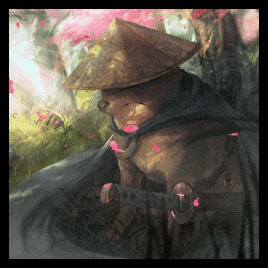

### Борьба с утечкой при кроссвалидации

Входные данные не были стандартизированы. Для решения этой задачи был выбран `StandardScaler`.
Но т.к. модель подбиралась с помощью кроссвалидации, то при скалировании всей тренировочной выборки могла произойти утечка данных о распределении признаков. Поэтому был использовани пайплайн, с помощью которого этой проблемы удалось избежать.

### Описание лучшей модели

Лучшей моделью по результатам кроссвалидации был выбран CatboostRegressor со следующими гиперпараметрами:

- Глубина дерева(пня) - depth = 5
- Количество итераций - iterations=1000
- Скорость обучения - learning rate=0.03

Целевая метрика (MAE) на тестовой выборке показала значение в 5.84 градуса. По данным кроссвалидации ожидается стандартное отклонение в 0.28 градуса при работе модели с другими, но похожими данными

#### Влияние признаков

CatboostRegressor - не лучшая модель в плане интерпретации, т.к. для визуализации ее работы необходимо будет строить все деревья. Но можно посмотреть на важность признаков. Их визуализирует следующий граф.

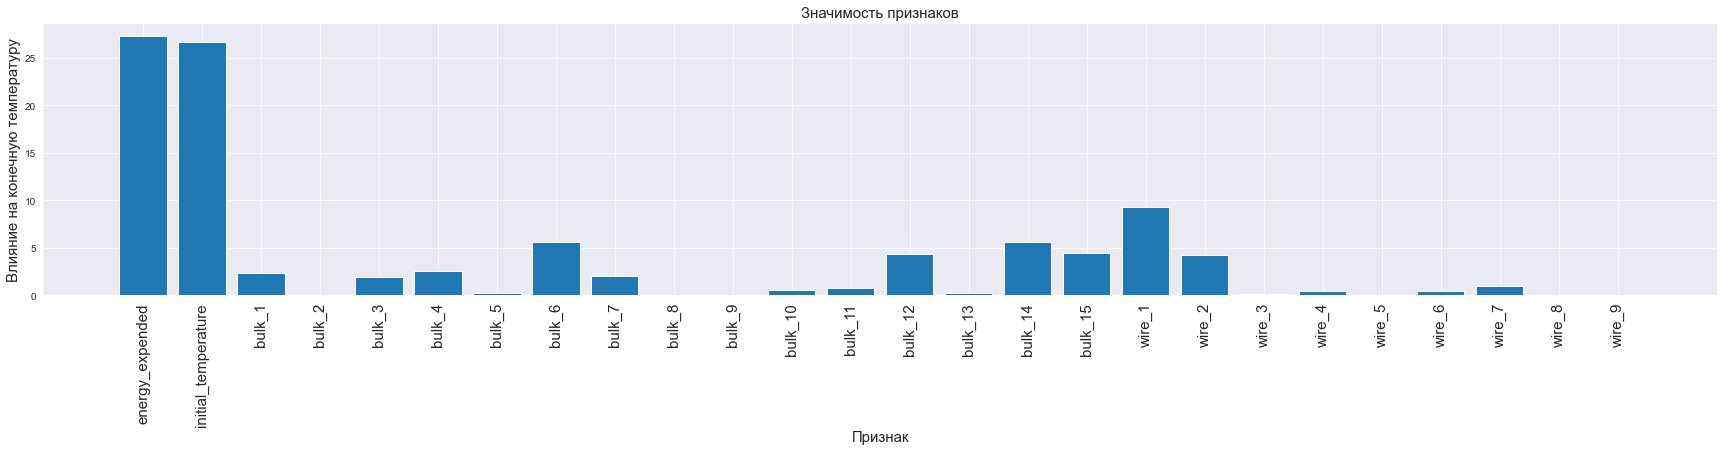

In [88]:
plt.figure(figsize = (30,5))
plt.bar(x_train.columns, grid_search_model.best_estimator_[1].feature_importances_)
plt.xticks(fontsize=15, rotation=90)
plt.title('Значимость признаков', fontsize=15)
plt.xlabel('Признак',fontsize=15)
plt.ylabel('Влияние на конечную температуру', fontsize=15)
plt.show()

Как видно, наиболее значимыми признаками при предсказании результата являются `начальная температура` и `затраченная полезная энергия`.

Вторым минусом модели градиентного бустинга можно выделить плохую экстраполяцию результатов. Поэтому заказчику крайне не рекомендуется брать экстремально низкие начальные температуры для работы. Модель этого не поймет. Желательно, чтобы данные не сильно отличались от привычных рабочих.